# 事前分布による推論の違い

参考記事  
http://machine-learning.hatenablog.com/entry/2016/02/20/213512  
http://machine-learning.hatenablog.com/entry/2016/03/02/071025

In [1]:
!date

2019年 8月17日 土曜日 22時59分05秒 JST


In [2]:
%matplotlib inline
%matplotlib nbagg

import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd
from tensorflow_probability import bijectors as tfb
from tensorflow_probability import edward2 as ed

from matplotlib.animation import ArtistAnimation
from IPython.display import HTML, display

warnings.filterwarnings('ignore')
plt.style.use('seaborn-darkgrid')
plt.rcParams['image.cmap'] = 'viridis'
sns.set_context('talk')

print('Tensorflow ver:', tf.version.VERSION)
print('Executing eagerly:', tf.executing_eagerly())

Tensorflow ver: 2.0.0-beta1
Executing eagerly: True


# Gaussian distribution

In [21]:
class Gauss:
    def __init__(self, mean=0., lmd=1., data_lmd=1., lb=-4., ub=4.):
        # Prior
        self.mean = mean
        self.lmd = lmd  # precision
        
        # Data variance (known for simplicity)
        self.data_lmd = data_lmd
        
        # Data range
        self.lb = lb
        self.ub = ub
        
    def inference(self, x):
        assert isinstance(x, (np.ndarray))
        
        prior_lmd = self.lmd
        self.lmd = len(x) * self.data_lmd + prior_lmd
        self.mean = ((self.data_lmd * x.sum() + prior_lmd * self.mean)
                         / self.lmd)
        
    def pdf(self, x=None):
        if x is None:
            x = np.linspace(self.lb, self.ub, 100)
            
        y = (np.exp(-(x - self.mean) ** 2 * self.lmd)
             * np.abs(self.lmd) ** 0.5 / np.sqrt(2 * np.pi))
            
        return x, y
    
    def sample(self, n=1):        
        return np.random.normal(loc=self.mean, scale=self.lmd ** -1,
                                size=n)

# Data

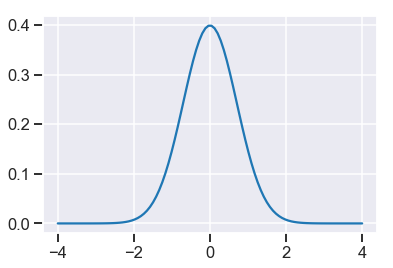

In [22]:
data_dist = Gauss()
plt.plot(*data_dist.pdf())
plt.show()

# Model 1

広めの事前分布

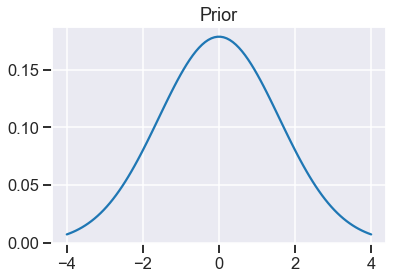

In [57]:
dist = Gauss(mean=0., lmd=0.2)
plt.plot(*dist.pdf())
plt.title('Prior')
plt.show()

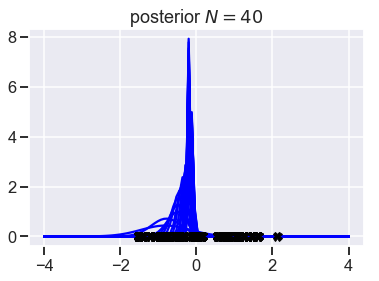

In [24]:
N = 40
dist = Gauss(mean=0., lmd=0.2)

data = []
frames = []
fig, ax = plt.subplots()
ax.set_title(r'posterior $N = {}$'.format(N))
for i in range(N):
    data.append(data_dist.sample())
    dist.inference(np.array(data))
    im1 = ax.plot(*dist.pdf(), c='b')
    im2 = ax.plot(data, np.zeros_like(data), 'X', c='k')
    frames.append(im1 + im2)

In [25]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())

# Model 2

偏った事前分布

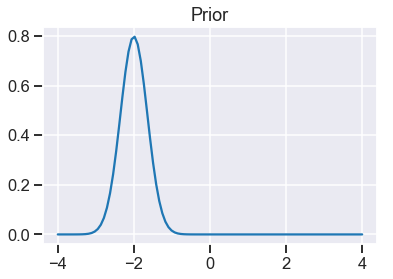

In [58]:
dist = Gauss(mean=-2., lmd=4)
plt.plot(*dist.pdf())
plt.title('Prior')
plt.show()

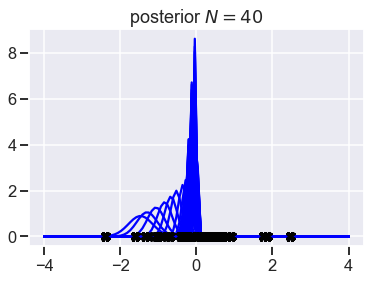

In [59]:
N = 40
dist = Gauss(mean=-2., lmd=4)

data = []
frames = []
fig, ax = plt.subplots()
ax.set_title(r'posterior $N = {}$'.format(N))
for i in range(N):
    data.append(data_dist.sample())
    dist.inference(np.array(data))
    im1 = ax.plot(*dist.pdf(), c='b')
    im2 = ax.plot(data, np.zeros_like(data), 'X', c='k')
    frames.append(im1 + im2)

In [60]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())

# Model 3

多峰性の事前分布

In [61]:
class MultiGauss:
    def __init__(self, mean=[1., -1.], lmd=[1., 1.], pi=[0.5, 0.5],
                 data_lmd=1., lb=-4., ub=4.):
        
        assert len(mean) == len(lmd) == len(pi)
        
        # Number of category
        self.k = len(mean)
        
        # Prior
        self.mean = np.array(mean)
        self.lmd = np.array(lmd)  # precision

        # Category probability
        self.pi = np.array(pi) / np.sum(pi)

        # Data variance (known for simplicity)
        self.data_lmd = data_lmd

        # Data range
        self.lb = lb
        self.ub = ub
        
    def inference(self, x):
        assert isinstance(x, (np.ndarray))
        
        prior_mean = self.mean
        prior_lmd = self.lmd
        
        # mu posterior
        self.lmd = len(x) * self.data_lmd + prior_lmd
        self.mean = ((self.data_lmd * x.sum() + prior_lmd * self.mean)
                         / self.lmd)
        
        # z posterior
        self.pi = np.exp(-prior_mean ** 2 * prior_lmd / 2 - np.log(np.sum(prior_lmd)) / 2
                         + self.mean ** 2 * self.lmd / 2 + np.log(np.sum(self.lmd)) / 2
                         + np.log(self.pi))
        self.pi /= self.pi.sum()
        
    def pdf(self, x=None):
        if x is None:
            x = np.linspace(self.lb, self.ub, 100)
            
        y = np.zeros_like(x)
        for i in range(self.k):
            y += self.pi[i] * (np.exp(-(x - self.mean[i]) ** 2 * self.lmd[i])
                               * np.abs(self.lmd[i]) ** 0.5 / np.sqrt(2 * np.pi))
            
        return x, y
    
    def sample(self, n=1):
        i = np.random.choice(self.k, p=self.pi)
        return np.random.normal(loc=self.mean[i], scale=self.lmd[i] ** -1,
                                size=n)

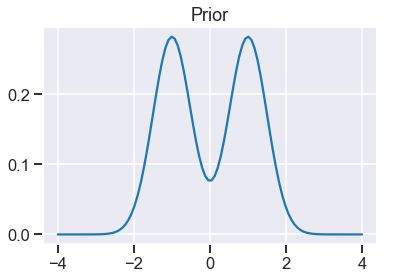

In [62]:
dist = MultiGauss(mean=[1., -1.], lmd=[2., 2.])
plt.plot(*dist.pdf())
plt.title('Prior')
plt.show()

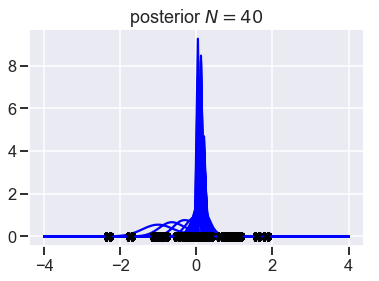

In [63]:
N = 40
dist = MultiGauss(mean=[1., -1.], lmd=[2., 2.])

data = []
frames = []
fig, ax = plt.subplots()
ax.set_title(r'posterior $N = {}$'.format(N))
for i in range(N):
    data.append(data_dist.sample())
    dist.inference(np.array(data))
    im1 = ax.plot(*dist.pdf(), c='b')
    im2 = ax.plot(data, np.zeros_like(data), 'X', c='k')
    frames.append(im1 + im2)

In [64]:
ani = ArtistAnimation(fig, frames)
HTML(ani.to_jshtml())